# Testing

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision import transforms
from torchvision import models
from torch import nn
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.patches as mpatches

In [ ]:
dataset_root = 'C:/DATASETS/AGE-FER'
dataset_imgs_path = os.path.join(dataset_root, 'images-preprocessed')
full_dataset_labels_path = os.path.join(dataset_root,'24-datasets.csv')

labels = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
label_map = { 'anger': 0,
              'disgust': 1,
              'fear': 2,
              'happiness': 3,
              'sadness': 4,
              'surprise': 5,
              'neutral': 6}

dtypes = {
    'dataset': 'category',
    'user_id': 'category',
    'name': str,
    'class': 'category',
    'age': 'Int8',
    'gender':'category' ,
    'race': 'category',
    'perspective': 'category',
    'age_group': 'category',
    'subset': 'category',
    'auto_age': bool,
    'auto_gender': bool,
    'auto_perspective': bool,
    'age_group_clean': 'category',
    'gaze': 'category',
    'key': 'category'}

In [4]:
class FERDataset(Dataset):
    def __init__(self, annotations_file, dtypes, img_dir, transform=None, target_transform=None, subdataset=None, age_group=None, balance=False):
        self.img_labels = pd.read_csv(annotations_file, dtype=dtypes, sep=',', quotechar='"')
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
        if subdataset:
            self.img_labels = self.img_labels[self.img_labels['dataset'] == subdataset]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, self.img_labels.columns.get_loc("name")]).lower()
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, self.img_labels.columns.get_loc("class")]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def get_model(model_name, num_classes, pretraining_dataset='IMAGENET1K_V1', in_channels=3):
    if model_name == 'ConvNeXt_Small':
        model = models.convnext_small(weights=pretraining_dataset)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
        model.features[0][0].in_channels = in_channels
    elif model_name == 'Swin_S':
        model = models.swin_s(weights=pretraining_dataset)
        model.head = nn.Linear(model.head.in_features, num_classes)
        model.features[0][0].in_channels = in_channels
    
    transform = models.get_weight(model_name + '_Weights.'+pretraining_dataset).transforms()
    
    return model, transform

def get_transform(default_transform, mode='train', augment=True):

    aug_transform = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            transforms.ColorJitter(brightness=0.25, contrast=0.25)] if augment else []

    if mode == 'train':
        return transforms.Compose(aug_transform + [default_transform])
    elif mode == 'test':
        return default_transform
    elif mode == 'augment':
        return transforms.Compose(aug_transform)
    else:
        raise ValueError('Invalid mode')
    
def save_preds(dataloader, model, out_path):
    model.eval()
    y_pred = []
    y_true = []
    
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        pred = model(X).argmax(dim=1)

        y_pred.extend(pred.cpu().numpy())
        y_true.extend(y.cpu().numpy())
            
    # Write predictions to compressed file
    with torch.no_grad():
        np.savez_compressed(out_path, y_true=y_true, y_pred=y_pred)

## Run evaluation

In [5]:
training_dir = os.path.join(dataset_root, 'training-augmented-weighted-loss')
models_dir = os.path.join(training_dir, 'models')
results_dir = os.path.join(training_dir, 'results')
chosen_models = ['ConvNeXt_Small', 'Swin_S']

# Get distinct datasets
df = pd.read_csv(full_dataset_labels_path, dtype=dtypes, sep=',', quotechar='"')
subdatasets = list(df['dataset'].unique())

# Set device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Compute Confusion Matrices

In [ ]:
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
training_subdatasets = subdatasets

for training_set in training_subdatasets:
    for test_set in training_subdatasets:
        for k_train in range(1, 6):
            for k_test in range(1, 6):

                # Skip training-test pairs with the same dataset but different folds
                if training_set == test_set and k_train != k_test:
                    continue

                for model_name in chosen_models:
                    
                    print(f"Model: {model_name}, Training set: {training_set}-{k_train}, Test set: {test_set}-{k_test}")
                    
                    model_path = os.path.join(models_dir, f'{model_name}_{training_set}_{k_train}.pth')
                    pred_path = os.path.join(results_dir, f'{model_name}_{training_set}_{k_train}_{test_set}_{k_test}_true-pred.npz')
                    
                    if not os.path.exists(pred_path):

                        # Define model, load pre-trained weights and get default transform
                        model, default_transform = get_model(model_name, len(labels), 'IMAGENET1K_V1')
                        model.load_state_dict(torch.load(model_path, weights_only=True))
                        model.to(device)

                        # Load the test dataset
                        test_data = FERDataset(
                            os.path.join(dataset_root, 'cv-labels', f'24-datasets_test_{k_test}.csv'),
                            dtypes, 
                            dataset_imgs_path, 
                            transform=default_transform,
                            target_transform=lambda label: label_map[label], 
                            subdataset=test_set)

                        # Create dataloaders
                        test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

                        # Save results
                        save_preds(test_dataloader, model, pred_path)

### Compute Accuracy, Precision, Recall, F1-Score

In [ ]:
columns = ['model', 'training_set', 'k_train', 'test_set', 'k_test','acc', 'macro_avg_prec', 'macro_avg_rec', 'macro_avg_f1', 'macro_avg_f1_cohens_kappa', 'weighted_avg_prec', 'weighted_avg_rec', 'weighted_avg_f1', 'total_support']+[f'prec_{label}' for label in labels]+[f'rec_{label}' for label in labels]+[f'f1_{label}' for label in labels]+[f'support_{label}' for label in labels]
df_results = pd.DataFrame(columns=columns)
training_subdatasets = subdatasets
chosen_models = ['ConvNeXt_Small', 'Swin_S']
progress = tqdm()

for training_set in training_subdatasets:
    print(f"Training set: {training_set}")
    for test_set in training_subdatasets:
        for k_train in range(1, 6):
            for k_test in range(1, 6):

                # Skip training-test pairs with the same dataset but different folds
                if training_set == test_set and k_train != k_test:
                    progress.update(len(chosen_models))
                    continue

                for model_name in chosen_models:

                    model_path = os.path.join(models_dir, f'{model_name}_{training_set}_{k_train}.pth')
                    pred_path = os.path.join(results_dir, f'{model_name}_{training_set}_{k_train}_{test_set}_{k_test}_true-pred.npz')
                    
                    # Load compressed ground truth and predictions
                    with np.load(pred_path) as data:
                        y_true = data['y_true']
                        y_pred = data['y_pred']

                    # Compute confusion matrix
                    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

                    # Compute metrics
                    support = np.sum(cm, axis=1)
                    total_support = np.sum(cm)
                    acc = np.diag(cm).sum() / cm.sum()
                    prec = np.nan_to_num(np.diag(cm) / np.sum(cm, axis=0), nan=0)
                    rec = np.nan_to_num(np.diag(cm) / np.sum(cm, axis=1), nan=0)
                    f1 = np.nan_to_num(2 * prec * rec / (prec + rec), nan=0)

                    macro_avg_prec = np.mean(prec[support > 0])
                    macro_avg_rec = np.mean(rec[support > 0])
                    macro_avg_f1 = np.mean(f1[support > 0])

                    p_e = 1 / np.count_nonzero(support)
                    macro_avg_f1_cohens_kappa = (macro_avg_f1 - p_e) / (1 - p_e)

                    weighted_avg_prec = np.sum(prec * support) / np.sum(support)
                    weighted_avg_rec = np.sum(rec * support) / np.sum(support)
                    weighted_avg_f1 = np.sum(f1 * support) / np.sum(support)

                    # Update results dataframe
                    df = pd.DataFrame([[model_name, training_set, k_train, test_set, k_test, acc, macro_avg_prec, macro_avg_rec, macro_avg_f1, macro_avg_f1_cohens_kappa, weighted_avg_prec, weighted_avg_rec, weighted_avg_f1, total_support]+list(prec)+list(rec)+list(f1)+list(support)], columns=columns)
                    df_results = pd.concat([df_results, df], ignore_index=True)

                    progress.update(1)
progress.close()

70it [00:00, 692.98it/s]

Training set: AffectNet


1196it [00:02, 483.00it/s]

Training set: BioVidEmo


2441it [00:05, 356.40it/s]

Training set: BU-4DFE


3611it [00:07, 402.72it/s]

Training set: CK+


4799it [00:10, 445.97it/s]

Training set: DDCF


6028it [00:13, 347.51it/s]

Training set: DEFSS


7229it [00:17, 303.44it/s]

Training set: ElderReact


8437it [00:20, 283.17it/s]

Training set: EMOREACT


9606it [00:23, 328.20it/s]

Training set: ExpW


10797it [00:27, 315.32it/s]

Training set: FACES


12007it [00:40, 82.24it/s] 

Training set: FEGA


13211it [00:53, 77.24it/s] 

Training set: FER2013


14412it [01:07, 75.50it/s] 

Training set: Google-FE-Test


15605it [01:20, 85.33it/s] 

Training set: JAFFE


16804it [01:34, 87.14it/s] 

Training set: KDEF


18009it [01:48, 73.85it/s] 

Training set: LIFESPAN


19203it [02:03, 79.97it/s] 

Training set: LIRIS


20405it [02:18, 77.51it/s] 

Training set: MMI


21610it [02:33, 68.47it/s] 

Training set: NHFI


22805it [02:48, 76.04it/s] 

Training set: NIMH-ChEFS


24004it [03:04, 71.78it/s] 

Training set: RAF-DB


25209it [03:19, 68.50it/s] 

Training set: RaFD


26401it [03:34, 84.45it/s] 

Training set: SFEW


27601it [03:50, 99.23it/s] 

Training set: WSEFEP


28800it [04:05, 117.20it/s]


In [ ]:
# Save dataframe to file
df_results.to_csv('df_results.csv', index=False)

## Display results

In [ ]:
# Load dataframe from file
df_results = pd.read_csv('df_results.csv')

# Choose performance metric to use for the similarity metrics
metric = 'macro_avg_f1'
metric_name = 'F1 score'

# Change some dataset names
for set in ['training_set', 'test_set']:
    for old_name, new_name in zip(['LIRIS', 'EMOREACT', 'LIFESPAN', 'Google-FE-Test'], ['LIRIS-CSE', 'EmoReact', 'Lifespan', 'FE-Test']):
        df_results[set] = df_results[set].str.replace(old_name, new_name)
        
subdatasets = list(df_results['training_set'].unique())

In [10]:
# Set df settings to show all columns
pd.set_option('display.max_columns', None)
df_results

,model,training_set,k_train,test_set,k_test,test_age_set,augmentation,balancing,acc,macro_avg_prec,macro_avg_rec,macro_avg_f1,macro_avg_f1_cohens_kappa,weighted_avg_prec,weighted_avg_rec,weighted_avg_f1,total_support,prec_anger,prec_disgust,prec_fear,prec_happiness,prec_sadness,prec_surprise,prec_neutral,rec_anger,rec_disgust,rec_fear,rec_happiness,rec_sadness,rec_surprise,rec_neutral,f1_anger,f1_disgust,f1_fear,f1_happiness,f1_sadness,f1_surprise,f1_neutral,support_anger,support_disgust,support_fear,support_happiness,support_sadness,support_surprise,support_neutral
0,ConvNeXt_Small,AffectNet,1,AffectNet,1,ALL,True,weighted-loss,0.722680,0.537545,0.605823,0.559746,0.486370,0.763197,0.722680,0.737556,51381,0.602462,0.293680,0.376471,0.951373,0.531590,0.321967,0.685274,0.553096,0.417989,0.521739,0.829651,0.612425,0.640631,0.665232,0.576725,0.344978,0.437358,0.886353,0.569151,0.428553,0.675105,4247,756,1104,24714,4314,2535,13711
1,Swin_S,AffectNet,1,AffectNet,1,ALL,True,weighted-loss,0.721570,0.524030,0.621810,0.552925,0.478413,0.763698,0.721570,0.737454,51381,0.552388,0.202216,0.357535,0.948974,0.510353,0.388875,0.707868,0.561102,0.579365,0.530797,0.844339,0.599907,0.603945,0.633214,0.556711,0.299795,0.427269,0.893604,0.551518,0.473115,0.668463,4247,756,1104,24714,4314,2535,13711
2,ConvNeXt_Small,AffectNet,2,AffectNet,2,ALL,True,weighted-loss,0.713625,0.539603,0.631786,0.564773,0.492235,0.770461,0.713625,0.732070,51429,0.492558,0.270146,0.417852,0.965998,0.611804,0.327668,0.691199,0.699160,0.511628,0.494855,0.807449,0.550974,0.733638,0.624801,0.577950,0.353591,0.453105,0.879637,0.579797,0.453008,0.656325,4165,688,1069,24700,4365,2628,13814
3,Swin_S,AffectNet,2,AffectNet,2,ALL,True,weighted-loss,0.719672,0.526750,0.633250,0.558267,0.484644,0.767473,0.719672,0.737137,51429,0.550301,0.195358,0.375422,0.960175,0.516804,0.391172,0.698019,0.614646,0.587209,0.520112,0.826761,0.616495,0.637367,0.630158,0.580696,0.293179,0.436078,0.888488,0.562265,0.484805,0.662355,4165,688,1069,24700,4365,2628,13814
4,ConvNeXt_Small,AffectNet,3,AffectNet,3,ALL,True,weighted-loss,0.734747,0.539463,0.623606,0.566193,0.493891,0.769326,0.734747,0.748218,51400,0.534052,0.211386,0.358120,0.952278,0.591066,0.431438,0.697899,0.645431,0.544837,0.547771,0.842889,0.569019,0.531063,0.684234,0.584483,0.304596,0.433094,0.894251,0.579833,0.476095,0.690999,4301,736,1099,24645,4209,2672,13738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27835,Swin_S,WSEFEP,3,WSEFEP,3,ALL,True,weighted-loss,0.964286,0.971429,0.964286,0.963719,0.957672,0.971429,0.964286,0.963719,28,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.857143,1.000000,1.000000,0.888889,1.000000,4,4,4,4,4,4,4
27836,ConvNeXt_Small,WSEFEP,4,WSEFEP,4,ALL,True,weighted-loss,0.972222,0.976190,0.971429,0.971140,0.966330,0.976852,0.972222,0.971942,36,1.000000,0.833333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,0.909091,1.000000,1.000000,0.888889,1.000000,1.000000,6,5,5,5,5,5,5
27837,Swin_S,WSEFEP,4,WSEFEP,4,ALL,True,weighted-loss,0.944444,0.952381,0.942857,0.942280,0.932660,0.953704,0.944444,0.943883,36,1.000000,1.000000,0.833333,1.000000,0.833333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,0.800000,1.000000,1.000000,0.909091,1.000000,0.909091,0.888889,0.888889,6,5,5,5,5,5,5
27838,ConvNeXt_Small,WSEFEP,5,WSEFEP,5,ALL,True,weighted-loss,0.910714,0.912132,0.910714,0.910504,0.895588,0.912132,0.910714,0.910504,56,0.875000,1.000000,0.857143,1.000000,0.875000,0.777778,1.000000,0.875000,1.000000,0.750000,1.000000,0.875000,0.875000,1.000000,0.875000,1.000000,0.800000,1.000000,0.875000,0.823529,1.000000,8,8,8,8,8,8,8


In [11]:
# Average rows of the same model, training_set, test_set, age_group, augmentation and balancing
df_results_avg = df_results.groupby(['model', 'training_set', 'test_set', 'augmentation', 'balancing']).mean(numeric_only=True).reset_index()
df_results_avg

,model,training_set,test_set,augmentation,balancing,k_train,k_test,acc,macro_avg_prec,macro_avg_rec,macro_avg_f1,macro_avg_f1_cohens_kappa,weighted_avg_prec,weighted_avg_rec,weighted_avg_f1,total_support,prec_anger,prec_disgust,prec_fear,prec_happiness,prec_sadness,prec_surprise,prec_neutral,rec_anger,rec_disgust,rec_fear,rec_happiness,rec_sadness,rec_surprise,rec_neutral,f1_anger,f1_disgust,f1_fear,f1_happiness,f1_sadness,f1_surprise,f1_neutral,support_anger,support_disgust,support_fear,support_happiness,support_sadness,support_surprise,support_neutral
0,ConvNeXt_Small,AffectNet,AffectNet,True,weighted-loss,3.0,3.0,0.726449,0.539343,0.624331,0.563466,0.490711,0.767979,0.726449,0.740940,51433.6,0.534974,0.232858,0.387385,0.948532,0.577747,0.388384,0.705523,0.642650,0.523959,0.540933,0.842312,0.564187,0.614951,0.641325,0.580747,0.314430,0.450420,0.891644,0.566831,0.469080,0.671112,4270.2,721.4,1104.6,24712.2,4288.0,2599.4,13737.8
1,ConvNeXt_Small,AffectNet,BU-4DFE,True,weighted-loss,3.0,3.0,0.639788,0.620274,0.672172,0.593510,0.525762,0.687100,0.639788,0.637242,291.2,0.611571,0.652019,0.649464,0.800987,0.656503,0.797260,0.174113,0.425989,0.647364,0.302843,0.955411,0.724629,0.788967,0.860000,0.488707,0.644416,0.407923,0.868155,0.682912,0.784473,0.277984,46.2,49.2,51.0,45.4,46.2,47.8,5.4
2,ConvNeXt_Small,AffectNet,BioVidEmo,True,weighted-loss,3.0,3.0,0.264960,0.396225,0.265044,0.262299,0.077874,0.396503,0.264960,0.262602,427.6,0.250162,0.573959,0.106429,0.794418,0.256158,0.000000,0.000000,0.296335,0.149488,0.006360,0.360993,0.512043,0.000000,0.000000,0.258912,0.221380,0.011832,0.486065,0.333305,0.000000,0.000000,86.0,85.4,85.2,86.0,85.0,0.0,0.0
3,ConvNeXt_Small,AffectNet,CK+,True,weighted-loss,3.0,3.0,0.850292,0.826300,0.824540,0.811574,0.780169,0.871270,0.850292,0.852719,259.0,0.607463,0.788546,0.836983,0.966193,0.710833,0.987790,0.886294,0.809973,0.835475,0.578030,0.975079,0.846147,0.872143,0.854930,0.683121,0.805328,0.666065,0.969923,0.763334,0.924774,0.868470,23.2,26.0,15.6,29.6,16.8,56.4,91.4
4,ConvNeXt_Small,AffectNet,DDCF,True,weighted-loss,3.0,3.0,0.787496,0.799576,0.788219,0.775417,0.737987,0.802750,0.787496,0.776634,669.8,0.862061,0.806750,0.838567,0.826311,0.742169,0.708361,0.812812,0.627343,0.885196,0.445197,0.984906,0.746457,0.934990,0.893442,0.722336,0.842956,0.573070,0.896467,0.741096,0.801508,0.850488,95.8,96.8,95.4,96.0,95.8,95.2,94.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,Swin_S,WSEFEP,NIMH-ChEFS,True,weighted-loss,3.0,3.0,0.667756,0.768218,0.666719,0.676507,0.595634,0.769343,0.667756,0.677495,106.6,0.722108,0.000000,0.969542,0.952494,0.523843,0.000000,0.673102,0.548848,0.000000,0.582303,0.987879,0.630465,0.000000,0.584099,0.603783,0.000000,0.712848,0.969332,0.532025,0.000000,0.564550,20.8,0.0,21.2,21.6,20.8,0.0,22.2
1148,Swin_S,WSEFEP,RAF-DB,True,weighted-loss,3.0,3.0,0.232512,0.340658,0.241703,0.193399,0.058965,0.521435,0.232512,0.273816,3067.2,0.049154,0.080334,0.085606,0.779511,0.218811,0.683898,0.487293,0.162948,0.521063,0.266562,0.292337,0.135102,0.130714,0.183194,0.066036,0.134173,0.127798,0.413316,0.148725,0.212385,0.251358,173.4,175.4,71.0,1191.2,492.0,323.4,640.8
1149,Swin_S,WSEFEP,RaFD,True,weighted-loss,3.0,3.0,0.647518,0.717776,0.647518,0.641071,0.581250,0.717776,0.647518,0.641071,844.2,0.636606,0.758076,0.826491,0.964591,0.459365,0.850024,0.529277,0.773242,0.882976,0.356086,0.764584,0.665249,0.648667,0.441822,0.682468,0.813542,0.481357,0.850161,0.515293,0.729388,0.415289,120.6,120.6,120.6,120.6,120.6,120.6,120.6
1150,Swin_S,WSEFEP,SFEW,True,weighted-loss,3.0,3.0,0.181004,0.273176,0.212127,0.160973,0.021135,0.324134,0.181004,0.162450,276.6,0.148289,0.083636,0.145052,0.833092,0.192959,0.291224,0.217979,0.059286,0.408690,0.213041,0.103155,0.292730,0.377016,0.030972,0.082051,0.133581,0.164594,0.176276,0.213213,0.306614,0.050483,50.2,17.4,28.8,54.2,48.2,30.6,4

In [12]:
training_dir = os.path.join(dataset_root, 'training')
results_dir = os.path.join(training_dir, 'results')
chosen_models = ['ConvNeXt_Small', 'Swin_S']

def grouped_bar(ax, x_labels, legend_and_y_values, y_title, title, x_title=None, leg_title=None, y_lim=None, width=0.25, multiplier=0, padding=3, show_values=True, leg_loc='upper left', mode='bar', leg_grid='y', title_size=22):
    
    x = np.arange(len(x_labels))  # the label locations
    legend_labels = []
    legend_colors = []

    for (label, value), color in zip(legend_and_y_values.items(), plt.rcParams['axes.prop_cycle'].by_key()['color']*10):
        offset = width * multiplier
        if mode == 'bar':
            rects = ax.bar(x + offset, value, width, label=label)
        elif mode == 'box':
            rects = ax.boxplot(value, positions=x + offset, vert=True, patch_artist=True, tick_labels=[value]*len(x_labels), widths=width)
            for patch in rects['boxes']:
                patch.set_facecolor(color)
            for median in rects['medians']:
                median.set_color('black')
            legend_labels.append(label)
            legend_colors.append(color)
        if show_values:
            ax.bar_label(rects, padding=padding)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.grid(axis = leg_grid, linestyle = 'dotted')
    ax.set_ylabel(y_title)
    ax.set_xlabel(x_title)
    ax.set_title(title, fontsize = title_size)
    ax.set_yticks(np.arange(y_lim[0], y_lim[1], (round(y_lim[1]-y_lim[0]))/10))
    ax.set_xticks(x + width, x_labels, rotation=90)
    if mode == 'bar':
        if leg_loc == 'outside':
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=leg_title)
        else:
            ax.legend(loc=leg_loc, title=leg_title)
    elif mode == 'box':
        if leg_loc == 'outside':
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            leg = ax.legend(loc='center left', handles=[mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)], bbox_to_anchor=(1, 0.5), title=leg_title)
        else:
            leg = ax.legend(loc=leg_loc, handles=[mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)], title=leg_title)
        
    if y_lim is not None:
        ax.set_ylim(y_lim[0], y_lim[1])

### Local Similarity

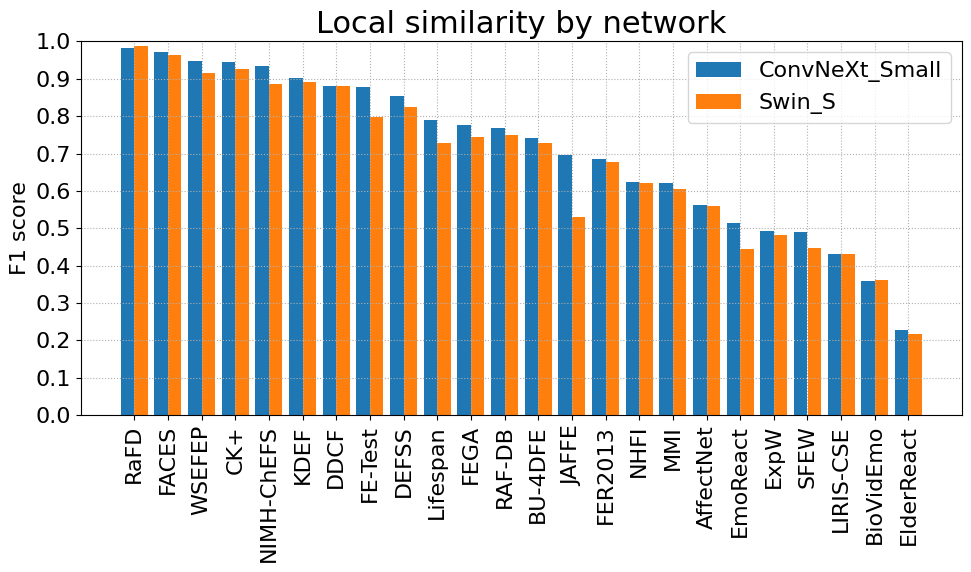

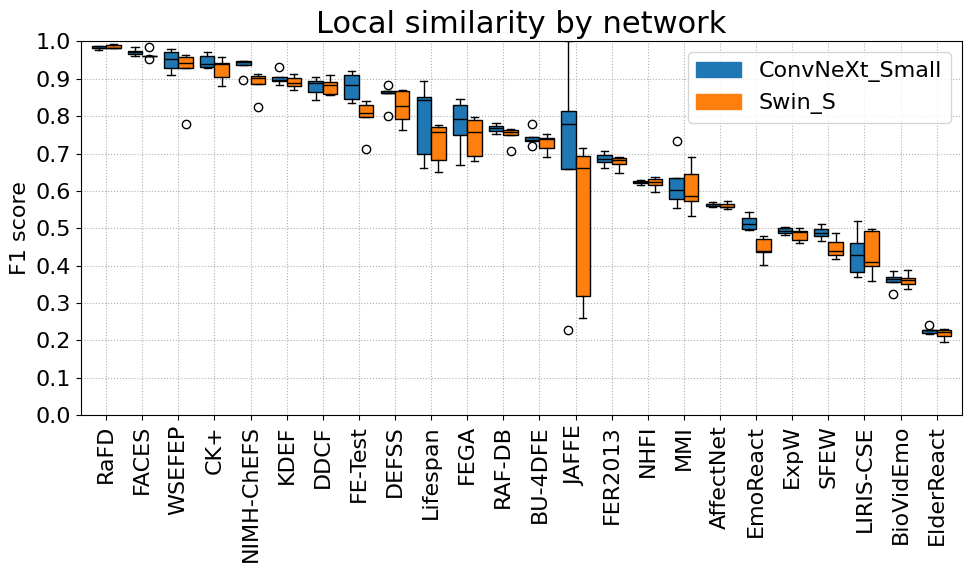

{'ConvNeXt_Small': array([0.56346615, 0.35998384, 0.74217249, 0.94580136, 0.87932257,
        0.85471816, 0.22698756, 0.51546257, 0.49396249, 0.97208376,
        0.77743793, 0.68543859, 0.8791661 , 0.69578302, 0.90205386,
        0.78967999, 0.43188868, 0.62064817, 0.62398992, 0.93454066,
        0.76700996, 0.98348355, 0.48884982, 0.94812339]),
 'Swin_S': array([0.56089693, 0.36063871, 0.72742301, 0.92525004, 0.88012899,
        0.82437481, 0.21787486, 0.44580121, 0.48245056, 0.96414692,
        0.74375124, 0.67602607, 0.79760795, 0.5299223 , 0.89110992,
        0.7277986 , 0.43181007, 0.60535033, 0.62173804, 0.88691709,
        0.74849565, 0.98641459, 0.4474304 , 0.9146046 ])}

In [13]:
chosen_subdatasets = subdatasets

legend_and_y_values = {}
legend_and_y_values2 = {}
for model_name in chosen_models:
    data = np.zeros(shape=[len(chosen_subdatasets)])
    data2 = np.zeros(shape=[5, len(chosen_subdatasets)])
    for i, dataset in enumerate(chosen_subdatasets):
        data[i] = np.mean(df_results[(df_results['training_set'] == dataset) & (df_results['test_set'] == dataset) & (df_results['model'] == model_name)][metric].values)
        data2[:, i] = df_results[(df_results['training_set'] == dataset) & (df_results['test_set'] == dataset) & (df_results['model'] == model_name)][metric].values
    legend_and_y_values[model_name] = data
    legend_and_y_values2[model_name] = data2

# Sort the subdatasets based on the values of the ConvNeXt_Small model
convnext_small_values = legend_and_y_values['ConvNeXt_Small']
sorted_indices = np.argsort(convnext_small_values)[::-1]  # Sort in descending order
sorted_subdatasets = [chosen_subdatasets[i] for i in sorted_indices]

# Reorder the data for all models based on the sorted subdatasets
sorted_legend_and_y_values = {}
for model_name, data in legend_and_y_values.items():
    sorted_legend_and_y_values[model_name] = [data[i] for i in sorted_indices]

# Reorder the data for all models based on the sorted subdatasets
sorted_legend_and_y_values2 = {}
for model_name, data in legend_and_y_values2.items():
    sorted_legend_and_y_values2[model_name] = [data[:, i] for i in sorted_indices]

# Plotting
plt.rcParams['font.size'] = 16

# Plot the grouped bar plot with the sorted subdatasets
fig, ax = plt.subplots(figsize=(10, 6))
grouped_bar(ax, sorted_subdatasets, sorted_legend_and_y_values, y_title=metric_name, title='Local similarity by network', leg_grid='both', mode='bar', y_lim=(0, 1.000001), width=0.4, multiplier=0.5, padding=0, show_values=False, leg_loc='upper right')
plt.tight_layout()
plt.show()

# Plot the grouped bar plot with the sorted subdatasets
fig, ax = plt.subplots(figsize=(10, 6))
grouped_bar(ax, sorted_subdatasets, sorted_legend_and_y_values2, y_title=metric_name, title='Local similarity by network', leg_grid='both', mode='box', y_lim=(0, 1.000001), width=0.4, multiplier=0.5, padding=0, show_values=False, leg_loc='upper right')
plt.tight_layout()
plt.show()

legend_and_y_values

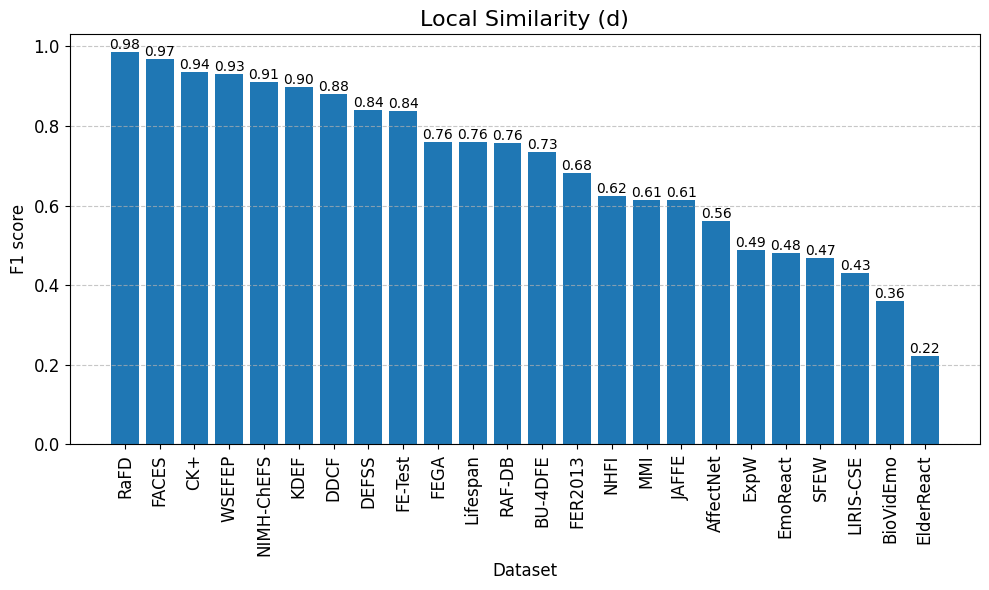

,subdataset,average_result
0,AffectNet,0.5622
1,BioVidEmo,0.3603
2,BU-4DFE,0.7348
3,CK+,0.9355
4,DDCF,0.8797
5,DEFSS,0.8395
6,ElderReact,0.2224
7,EmoReact,0.4806
8,ExpW,0.4882
9,FACES,0.9681


In [14]:
chosen_subdatasets = subdatasets

legend_and_y_values = {}
for model_name in chosen_models:
    data = np.zeros(shape=[len(chosen_subdatasets)])
    for i, dataset in enumerate(chosen_subdatasets):
        data[i] = np.mean(df_results[(df_results['training_set'] == dataset) & (df_results['test_set'] == dataset)][metric].values)
    legend_and_y_values[model_name] = data

# Compute the average results for each subdataset
average_results = np.mean(list(legend_and_y_values.values()), axis=0)

# Create a DataFrame for easier sorting
results_df = pd.DataFrame({'subdataset': chosen_subdatasets, 'average_result': average_results})

# Sort the DataFrame in descending order based on the average results
sorted_results_df = results_df.sort_values(by='average_result', ascending=False)

# Plotting
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the sorted average results in a bar chart
bars = ax.bar(sorted_results_df['subdataset'], sorted_results_df['average_result'])
ax.set_title('Local Similarity (d)', fontsize=16)
ax.set_xlabel('Dataset')
ax.set_ylabel(metric_name)
plt.xticks(rotation=90)

# Add grid to the y-axis
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Set y limit
ax.set_ylim(0, 1.03)

# Add values on top of each bar
plt.rcParams['font.size'] = 10
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

results_df.apply(lambda x: round(x, 4))

### Global Similarity

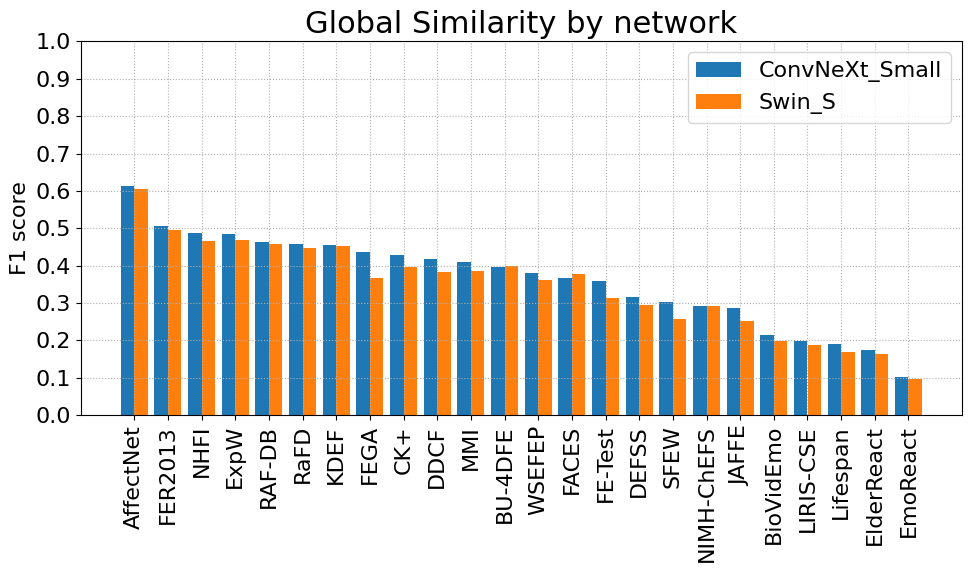

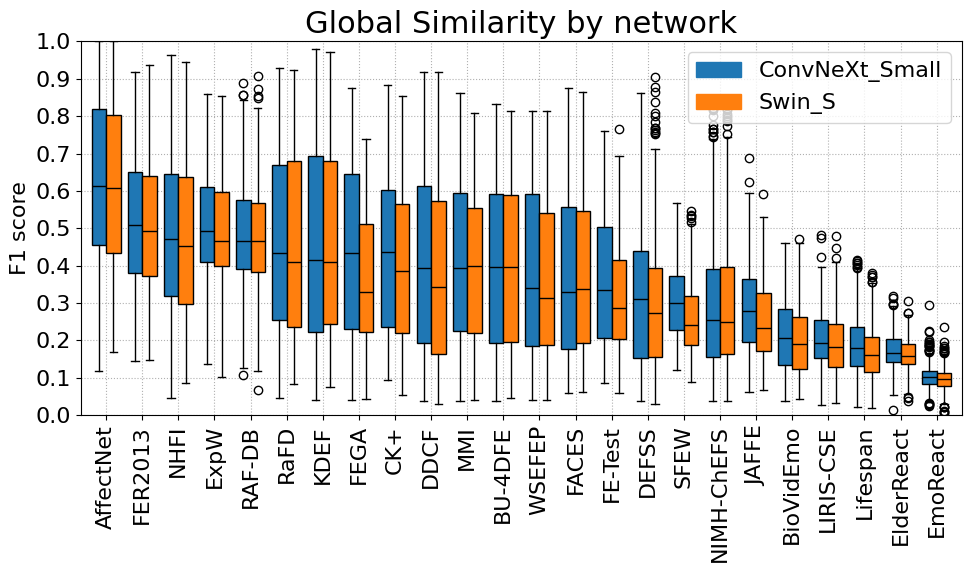

{'ConvNeXt_Small': array([0.6131871 , 0.21419768, 0.39600339, 0.42897648, 0.4166319 ,
        0.31497606, 0.17411454, 0.10344412, 0.48605268, 0.36830445,
        0.43741713, 0.50655451, 0.35881771, 0.28725002, 0.45633481,
        0.18959574, 0.19950684, 0.40947466, 0.48845461, 0.29230298,
        0.46367606, 0.45726997, 0.3033011 , 0.37990984]),
 'Swin_S': array([0.6054916 , 0.19875845, 0.39912647, 0.39529321, 0.38244356,
        0.29606058, 0.16424884, 0.09613742, 0.46891408, 0.37759515,
        0.36754654, 0.49521178, 0.31440436, 0.2517912 , 0.4516886 ,
        0.16836018, 0.18911987, 0.3862083 , 0.46733055, 0.29226953,
        0.45788257, 0.44785355, 0.25862242, 0.36211623])}

In [15]:
chosen_subdatasets = subdatasets

legend_and_y_values = {}
legend_and_y_values2 = {}
for model_name in chosen_models:
    data1 = np.zeros(shape=[len(chosen_subdatasets)])
    data2 = np.zeros(shape=[(len(chosen_subdatasets)-1)*25, len(chosen_subdatasets)])
    for j, training_set in enumerate(chosen_subdatasets):
        data = np.zeros(shape=[len(chosen_subdatasets)-1])
        data3 = np.zeros(shape=[25, len(chosen_subdatasets)-1])
        counter_i = 0
        for test_set in chosen_subdatasets:
            if training_set == test_set:
                continue
            data[counter_i] = np.mean(df_results[(df_results['training_set'] == training_set) & (df_results['test_set'] == test_set) & (df_results['model'] == model_name)][metric].values)
            data3[:, counter_i] = df_results[(df_results['training_set'] == training_set) & (df_results['test_set'] == test_set) & (df_results['model'] == model_name)][metric].values
            counter_i += 1
        data1[j] = np.mean(data)
        data2[:, j] = data3.reshape(-1)
    legend_and_y_values[model_name] = data1
    legend_and_y_values2[model_name] = data2

# Sort the subdatasets based on the values of the ConvNeXt_Small model
convnext_small_values = legend_and_y_values['ConvNeXt_Small']
sorted_indices = np.argsort(convnext_small_values)[::-1]  # Sort in descending order
sorted_subdatasets = [chosen_subdatasets[i] for i in sorted_indices]

# Reorder the data for all models based on the sorted subdatasets
sorted_legend_and_y_values = {}
for model_name, data in legend_and_y_values.items():
    sorted_legend_and_y_values[model_name] = [data[i] for i in sorted_indices]

# Reorder the data for all models based on the sorted subdatasets
sorted_legend_and_y_values2 = {}
for model_name, data in legend_and_y_values2.items():
    sorted_legend_and_y_values2[model_name] = [data[:, i] for i in sorted_indices]

# Plotting
plt.rcParams['font.size'] = 16

# Plot the grouped bar plot with the sorted subdatasets
fig, ax = plt.subplots(figsize=(10, 6))
grouped_bar(ax, sorted_subdatasets, sorted_legend_and_y_values, y_title=metric_name, title='Global Similarity by network', leg_grid='both', mode='bar', y_lim=(0, 1.000001), width=0.4, multiplier=0.5, padding=0, show_values=False, leg_loc='upper right')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
grouped_bar(ax, sorted_subdatasets, sorted_legend_and_y_values2, y_title=metric_name, title='Global Similarity by network', leg_grid='both', mode='box', y_lim=(0, 1.000001), width=0.4, multiplier=0.5, padding=0, show_values=False, leg_loc='upper right')
plt.tight_layout()
plt.show()

legend_and_y_values

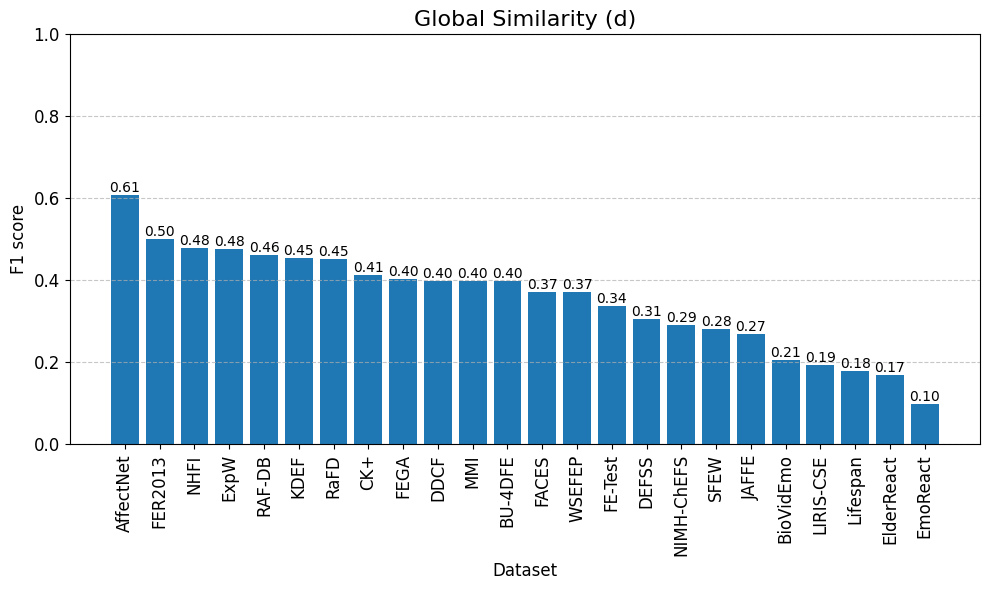

,subdataset,average_result
0,AffectNet,0.6093
1,BioVidEmo,0.2065
2,BU-4DFE,0.3976
3,CK+,0.4121
4,DDCF,0.3995
5,DEFSS,0.3055
6,ElderReact,0.1692
7,EmoReact,0.0998
8,ExpW,0.4775
9,FACES,0.3729


In [16]:
chosen_subdatasets = subdatasets

legend_and_y_values = {}
legend_and_y_values2 = {}
for model_name in chosen_models:
    data1 = np.zeros(shape=[len(chosen_subdatasets)])
    for j, training_set in enumerate(chosen_subdatasets):
        data = np.zeros(shape=[len(chosen_subdatasets)-1])
        counter_i = 0
        for test_set in chosen_subdatasets:
            if training_set == test_set:
                continue
            data[counter_i] = np.mean(df_results[(df_results['training_set'] == training_set) & (df_results['test_set'] == test_set) & (df_results['model'] == model_name)][metric].values)
            counter_i += 1
        data1[j] = np.mean(data)
    legend_and_y_values[model_name] = data1

# Compute the average results for each subdataset
average_results = np.mean(list(legend_and_y_values.values()), axis=0)

# Create a DataFrame for easier sorting
results_df = pd.DataFrame({'subdataset': chosen_subdatasets, 'average_result': average_results})

# Sort the DataFrame in descending order based on the average results
sorted_results_df = results_df.sort_values(by='average_result', ascending=False)

# Plotting
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the sorted average results in a bar chart
bars = ax.bar(sorted_results_df['subdataset'], sorted_results_df['average_result'])
ax.set_title('Global Similarity (d)', fontsize=16)
ax.set_xlabel('Dataset')
ax.set_ylabel(metric_name)
plt.xticks(rotation=90)

# Add grid to the y-axis
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Set y limit
ax.set_ylim(0, 1)

# Add values on top of each bar
plt.rcParams['font.size'] = 10
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

results_df.apply(lambda x: round(x, 4))

### Paired Similarity

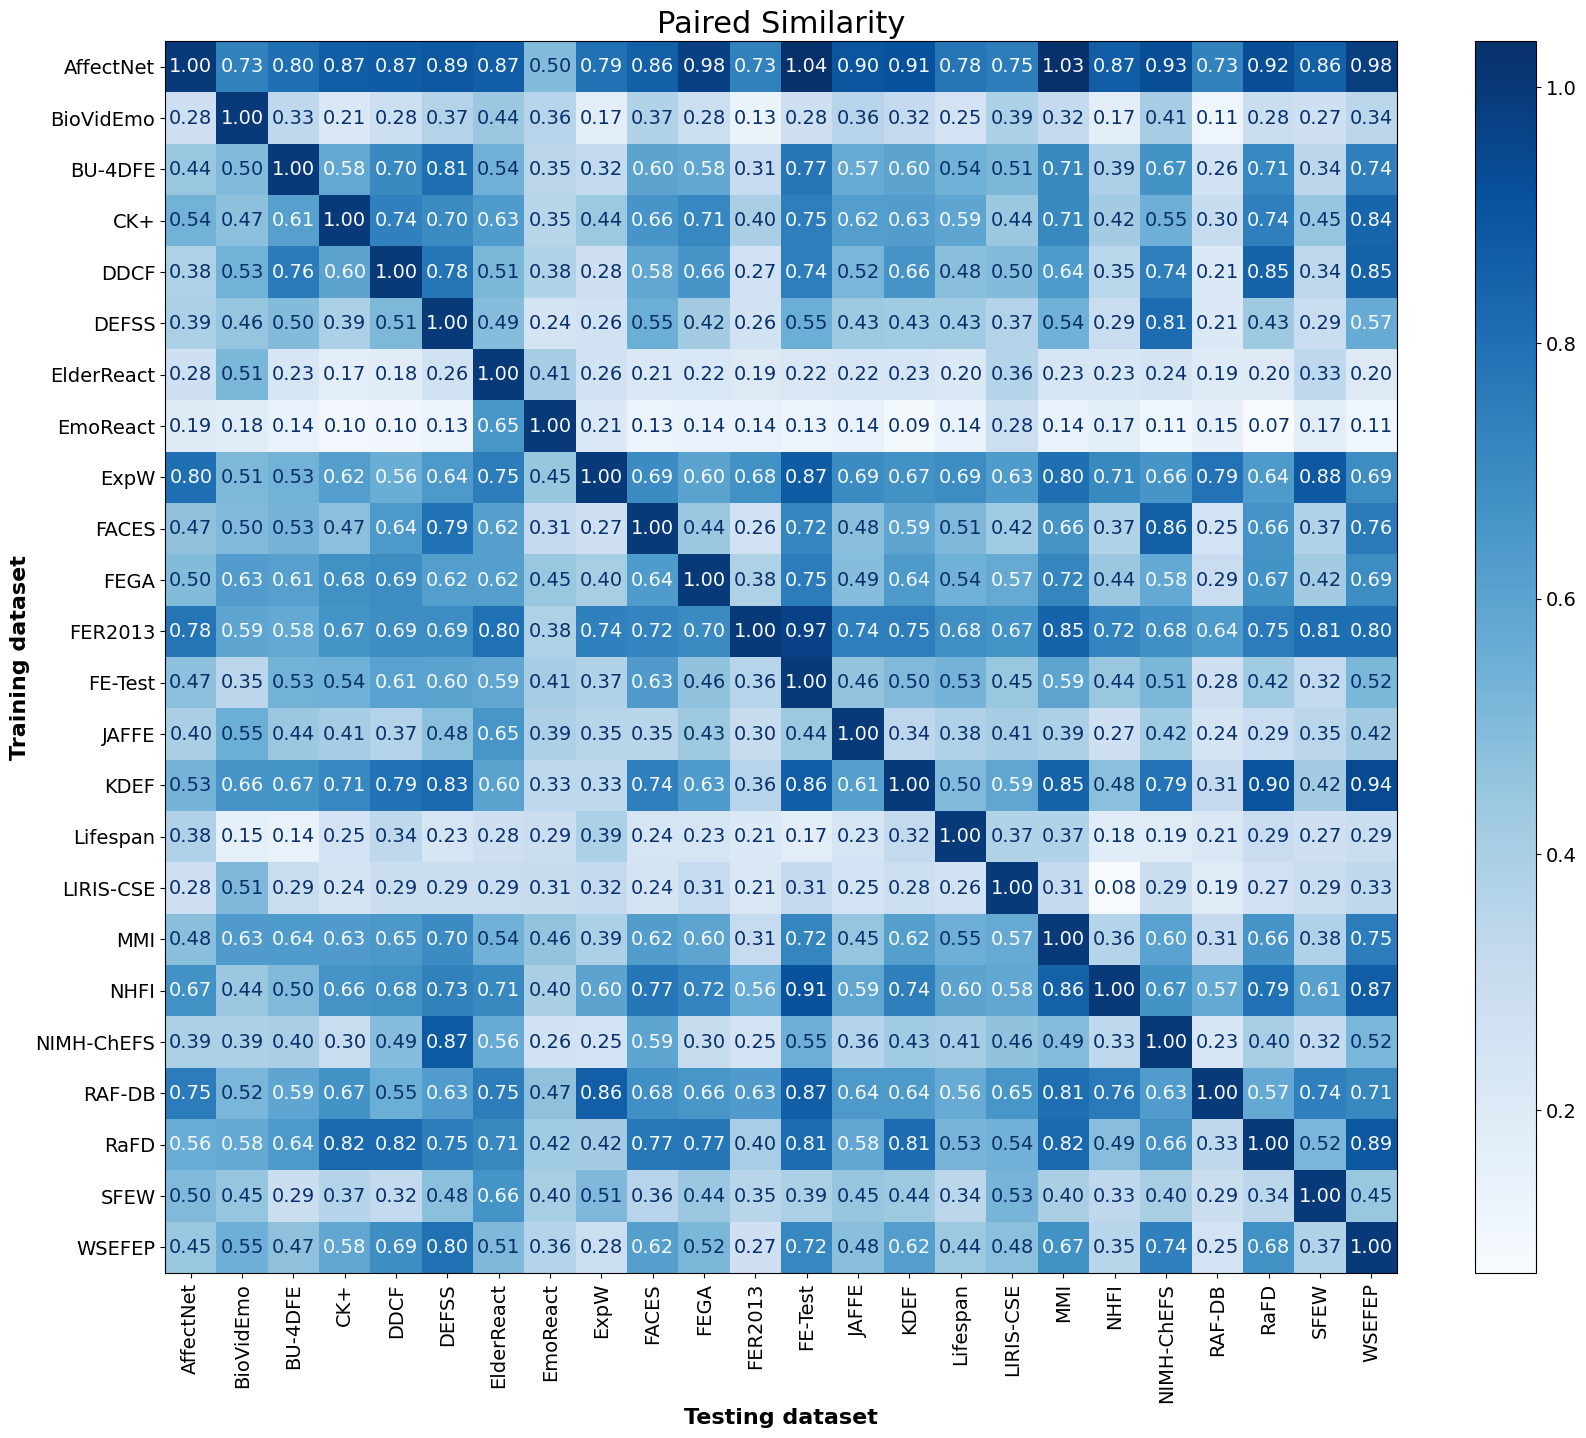

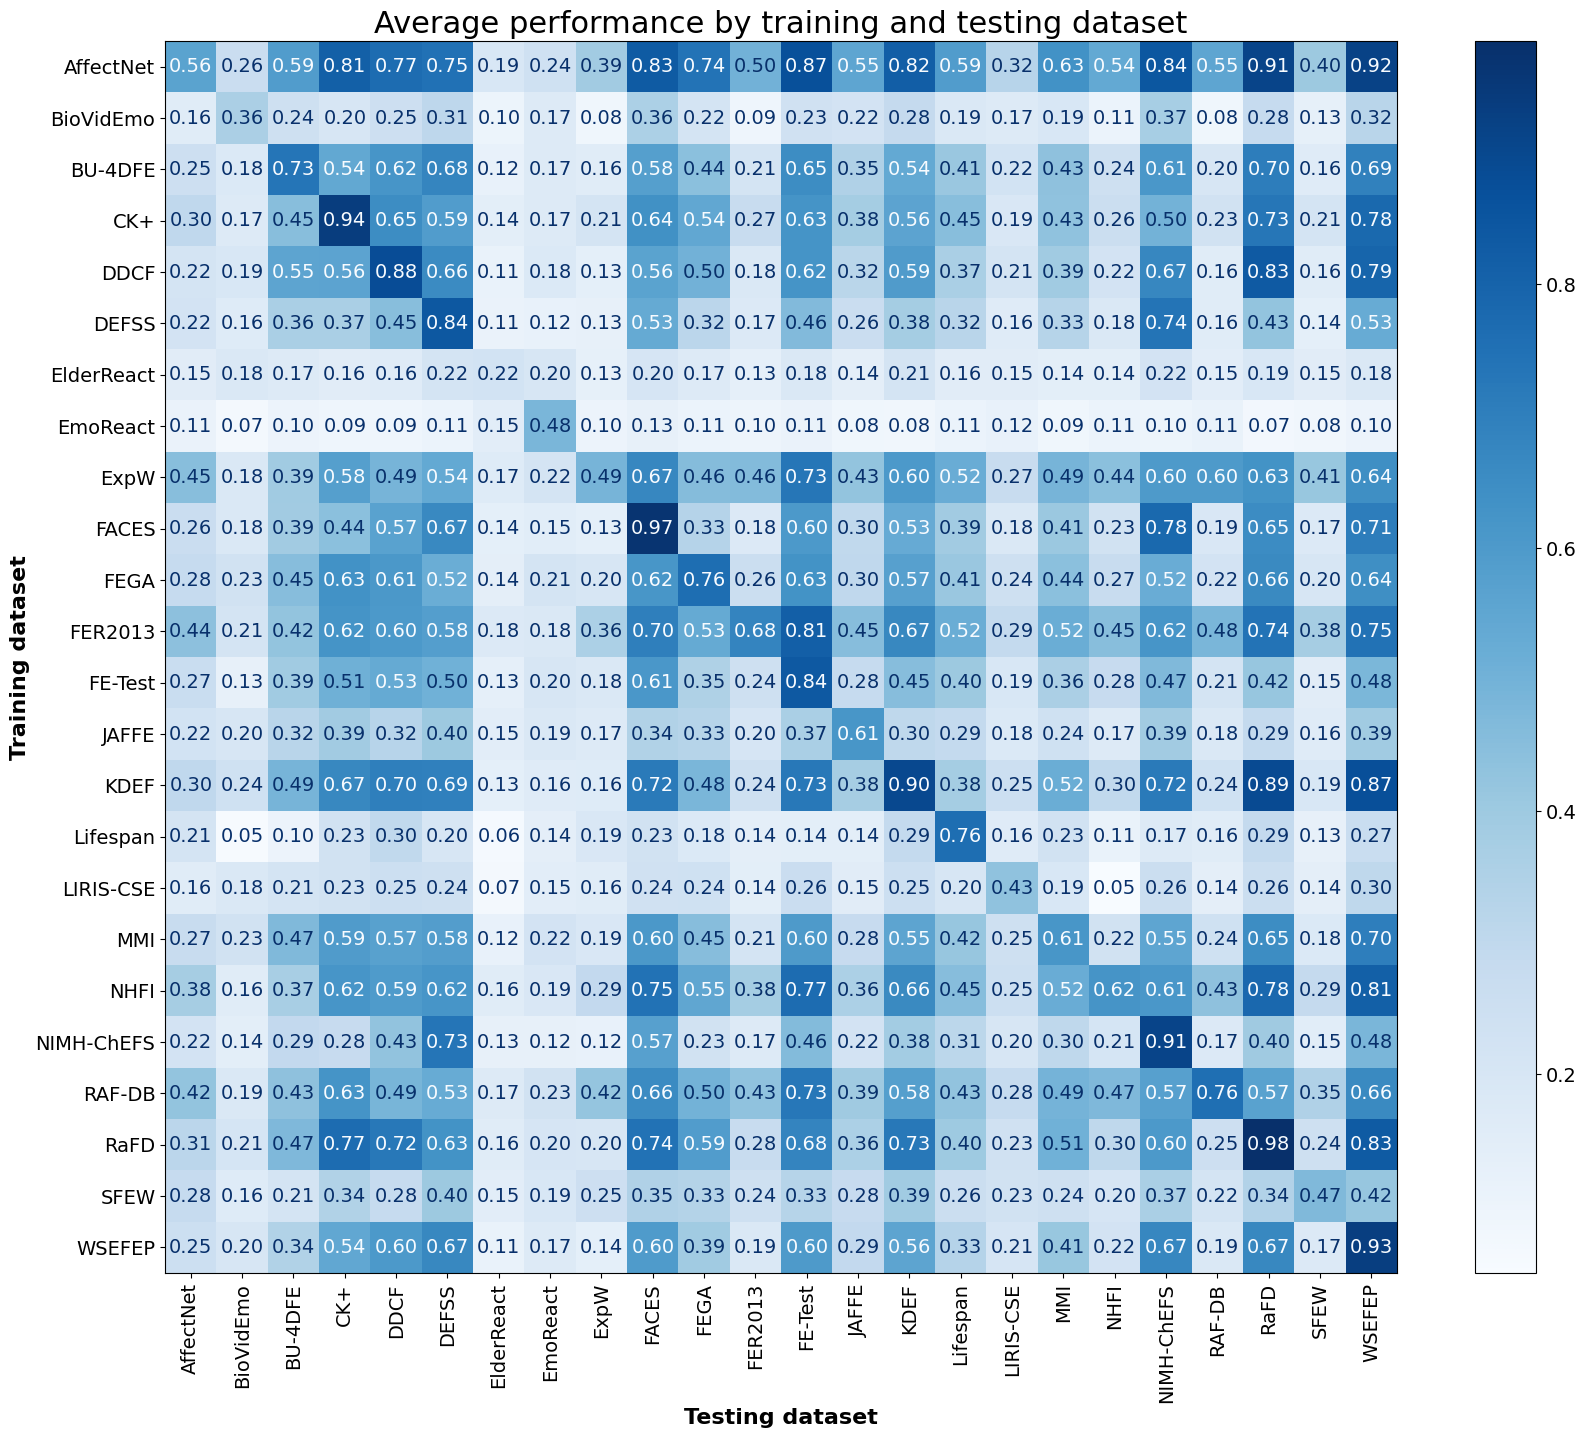

In [17]:
chosen_subdatasets = subdatasets

ev_matrix = np.zeros(shape=[len(chosen_subdatasets), len(chosen_subdatasets)])
red_matrix = np.zeros(shape=[len(chosen_subdatasets), len(chosen_subdatasets)])
for y, training_set in enumerate(chosen_subdatasets):
    for x, test_set in enumerate(chosen_subdatasets):
        a = np.mean(df_results[(df_results['training_set'] == training_set) & (df_results['test_set'] == test_set)][metric].values) 
        b = np.mean(df_results[(df_results['training_set'] == test_set) & (df_results['test_set'] == test_set)][metric].values) # Difficulty(d)
        red_matrix[y, x] = a/b if b > 0 else 0
        ev_matrix[y, x] = a

# Plot confusion matrix

plt.rcParams['font.size'] = 14
disp = ConfusionMatrixDisplay(confusion_matrix=red_matrix, display_labels=chosen_subdatasets)
disp.plot(xticks_rotation='vertical', cmap='Blues', values_format='.2f')

fig = disp.ax_.get_figure() 
fig.set_figwidth(20)
fig.set_figheight(16)  

# In bold
plt.ylabel('Training dataset', fontweight='bold', fontsize=16)
plt.xlabel('Testing dataset', fontweight='bold', fontsize=16)
plt.title('Paired Similarity', fontsize=22)
plt.show()

# Plot confusion matrix
plt.rcParams['font.size'] = 14
disp = ConfusionMatrixDisplay(confusion_matrix=ev_matrix, display_labels=chosen_subdatasets)
disp.plot(xticks_rotation='vertical', cmap='Blues', values_format='.2f')

fig = disp.ax_.get_figure()
fig.set_figwidth(20)
fig.set_figheight(16)  

# In bold
plt.ylabel('Training dataset', fontweight='bold', fontsize=16)
plt.xlabel('Testing dataset', fontweight='bold', fontsize=16)
plt.title('Average performance by training and testing dataset', fontsize=22)
plt.show()